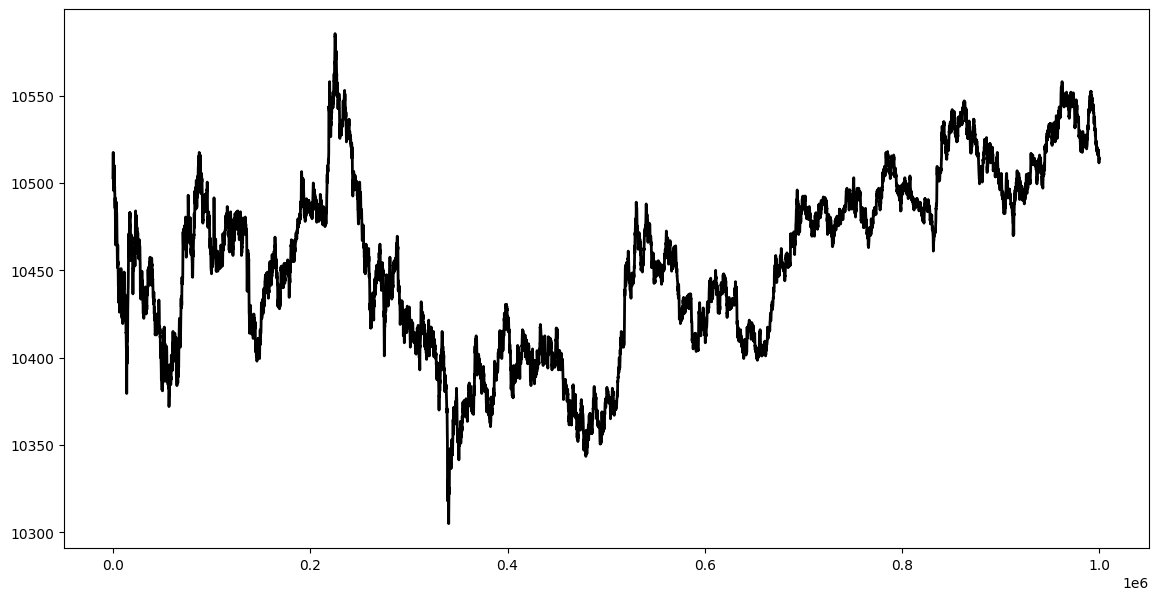

interactive(children=(Dropdown(description='t', options=(np.int64(0), np.int64(100), np.int64(200), np.int64(3…

<function __main__.plot_smile_at_time(t)>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Load CSVs
day_0 = pd.read_csv("./r3data/prices_round_3_day_0.csv", delimiter=";")


def get_adjusted(df, product, shift=0, tte=0):
    df = df[df["product"] == product].copy()
    df["timestamp"] += shift
    df["TTE"] = tte
    return df


# Black-Scholes functions
#v_t
def black_scholes_price(S, K, r, T, sigma, option_type="call"):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(market_price, S, K, r, T, option_type="call"):
    if market_price < 1e-5:
        return float('nan')

    # Binary search bounds
    low, high = 1e-6, 5.0
    for _ in range(100):
        mid = (low + high) / 2
        price = black_scholes_price(S, K, r, T, mid, option_type)
        if abs(price - market_price) < 1e-5:
            return mid
        if price > market_price:
            high = mid
        else:
            low = mid
    return (low + high) / 2


# --- Pull underlying price ---
underlying = pd.concat([
    get_adjusted(day_0, "VOLCANIC_ROCK", shift=0, tte=8),
])[["timestamp", "mid_price", "TTE"]].rename(columns={"mid_price": "St"})
underlying["TTE_years"] = underlying["TTE"] / 365.0

# Plot setup
plt.figure(figsize=(14, 7))
plt.plot(underlying["timestamp"], underlying["St"], label="Underlying Price (VOLCANIC_ROCK)", color="black",
         linewidth=2)

# Voucher strikes to process
strike_prices = [9500, 9750, 10000, 10250, 10500]
r = 0.01

from ipywidgets import interact
import matplotlib.pyplot as plt

base_iv_data = []  # Store (t, base_iv) pairs


def plot_smile_at_time(t):
    plt.figure(figsize=(10, 5))
    all_mt_vt_t = []

    for strike in strike_prices:
        product = f"VOLCANIC_ROCK_VOUCHER_{strike}"
        voucher = get_adjusted(day_0, product, shift=0, tte=8)
        voucher_t = voucher[voucher["timestamp"] == t][["timestamp", "mid_price"]].rename(columns={"mid_price": "Vt"})
        underlying_t = underlying[underlying["timestamp"] == t]

        if len(voucher_t) == 0 or len(underlying_t) == 0:
            continue

        row = pd.merge(underlying_t, voucher_t, on="timestamp")
        row["K"] = strike
        row["m_t"] = np.log(row["K"] / row["St"]) / np.sqrt(row["TTE_years"])
        row["v_t"] = row.apply(lambda r: implied_volatility(r["Vt"], r["St"], r["K"], r=0.01, T=r["TTE_years"]), axis=1)
        all_mt_vt_t.append(row[["K", "m_t", "v_t"]])
        plt.scatter(row["m_t"], row["v_t"], label=f"K={strike}")

    combined = pd.concat(all_mt_vt_t).dropna()
    if len(combined) >= 3:
        coeffs = np.polyfit(combined["m_t"], combined["v_t"], deg=2)
        poly = np.poly1d(coeffs)
        x_fit = np.linspace(combined["m_t"].min(), combined["m_t"].max(), 100)
        y_fit = poly(x_fit)
        plt.plot(x_fit, y_fit, 'k--', label="Smile Fit")
        base_iv = poly(0)
        plt.title(f"Volatility Smile at t={t} | Base IV = {base_iv:.4f}")

        # --- Store base_iv for plotting over time ---
        base_iv_data.append((t, base_iv))

        # --- Compute and print error ---
        combined["fitted_vt"] = poly(combined["m_t"])
        combined["error"] = combined["v_t"] - combined["fitted_vt"]

        if combined["error"].abs().max() > 0.0001:
            print(f"OPPORTUNITY: Max error = {combined['error'].abs().max():.5f} at K={combined['K'].max()}")

        print("Strike | m_t     | IV (v_t) | Fitted IV | Error")
        for _, row in combined.iterrows():
            print(
                f"{int(row['K']):<6} | {row['m_t']:+.4f} | {row['v_t']:.5f} | {row['fitted_vt']:.5f} | {row['error']:+.5f}")
    else:
        plt.title(f"No data for t={t}")

    plt.xlabel("m_t = log(K/St)/sqrt(TTE)")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- New plot: base IV over time ---
    if len(base_iv_data) >= 2:
        times, base_ivs = zip(*sorted(base_iv_data))
        plt.figure(figsize=(10, 3))
        plt.plot(times, base_ivs, marker="o")
        plt.title("Base IV over Time")
        plt.xlabel("Timestamp")
        plt.ylabel("Base IV (Smile at m_t=0)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


interact(plot_smile_at_time, t=sorted(underlying["timestamp"].unique()))